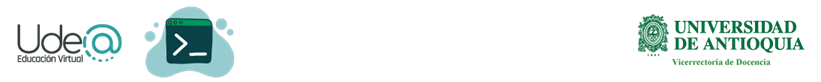

# <h1><center>Visualizing embeddings with t-SNE</center></h1>

**Especialización en Analítica de Datos**

*Prof. Hernán Felipe García Arias*

*Facultad de Ingeniería*

*Universidad de Antioquia*


**2025-2**


## Overview

This tutorial demonstrates how to visualize and perform clustering with the embeddings from the Gemini API. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html){:.external} and cluster that subset using the KMeans algorithm.

For more information on getting started with embeddings generated from the Gemini API, check out the [Python quickstart](https://ai.google.dev/gemini-api/docs/get-started/python#use_embeddings).

## Prerequisites

You can run this quickstart in Google Colab.

To complete this quickstart on your own development environment, ensure that your envirmonement meets the following requirements:

-  Python 3.9+
-  An installation of `jupyter` to run the notebook.

## Setup

First, download and install the Gemini API Python library.

In [5]:
!pip install -U -q google-generativeai

In [6]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import google.generativeai as genai

# Used to securely store your API key
from google.colab import userdata

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Grab an API Key

Before you can use the Gemini API, you must first obtain an API key. If you don't already have one, create a key with one click in Google AI Studio.

<a class="button button-primary" href="https://makersuite.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `API_KEY`.

Once you have the API key, pass it to the SDK. You can do this in two ways:

* Put the key in the `GOOGLE_API_KEY` environment variable (the SDK will automatically pick it up from there).
* Pass the key to `genai.configure(api_key=...)`

In [7]:
# Or use `os.getenv('API_KEY')` to fetch an environment variable.
API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=API_KEY)

Key Point: Next, you will choose a model. Any embedding model will work for this tutorial, but for real applications it's important to choose a specific model and stick with it. The outputs of different models are not compatible with each other.

**Note**: At this time, the Gemini API is [only available in certain regions](https://ai.google.dev/gemini-api/docs/available-regions).

In [8]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp
models/gemini-embedding-001


## Dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will be using the training subset.

In [9]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [10]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [11]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

In [12]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)
# Retain text samples that can be used in the gecko model.
df_train = df_train[df_train['Text'].str.len() < 10000]

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, you will sample some of the data by taking 100 data points in the training dataset, and dropping a few of the categories to run through this tutorial. Choose the science categories to compare.

In [13]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

/tmp/ipython-input-406673449.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(SAMPLE_SIZE))


,index,Text,Label,Class Name
0,1650,Re: text of White House announcement and Q&As...,11,sci.crypt
1,1651,Re: PEM and MIME\nOrganization: Personal Usen...,11,sci.crypt
2,1652,Need source of FEAL encrytion algorithm\nOrga...,11,sci.crypt
3,1653,Re: Fifth Amendment and Passwords\nIn-Reply-T...,11,sci.crypt
4,1654,What is going on?...\nLines: 26\nOrganization...,11,sci.crypt
...,...,...,...,...
595,2245,Washington Post Article on US-Russian Space C...,14,sci.space
596,2246,Re: Eco-Freaks forcing Space Mining.\nOrganiz...,14,sci.space
597,2247,Re: New planet/Kuiper object found?\nOrganiza...,14,sci.space
598,2248,MUNIZB% Alaska Pipeline and Space Station!\nX-...,14,sci.space


In [14]:
df_train['Class Name'].value_counts()

,count
Class Name,
sci.crypt,150
sci.electronics,150
sci.med,150
sci.space,150


## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

### API changes to Embeddings with model embedding-001

For the new embeddings model, embedding-001, there is a new task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")
    return embedding["embedding"]

  return embed_fn

def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(df_train)

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
aux = df_train.iloc[0]['Embeddings']
aux

## Dimensionality reduction

The length of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [ ]:
len(df_train['Embeddings'][0])

In [ ]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [ ]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

In [ ]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

## Compare results to KMeans

[KMeans clustering](https://developers.google.com/machine-learning/glossary#k-means){:.external} is a popular clustering algorithm and used often for unsupervised learning. It iteratively determines the best k center points, and assigns each example to the closest centroid. Input the embeddings directly into the KMeans algorithm to compare the visualization of the embeddings to the performance of a machine learning algorithm.

In [ ]:
# Apply KMeans
kmeans_model = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(X)
labels = kmeans_model.fit_predict(X)

In [ ]:
df_tsne['Cluster'] = labels
df_tsne

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using KMeans Clustering');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

In [ ]:
def get_majority_cluster_per_group(df_tsne_cluster, class_names):
  class_clusters = dict()
  for c in class_names:
    # Get rows of dataframe that are equal to c
    rows = df_tsne_cluster.loc[df_tsne_cluster['Class Name'] == c]
    # Get majority value in Cluster column of the rows selected
    cluster = rows.Cluster.mode().values[0]
    # Populate mapping dictionary
    class_clusters[c] = cluster
  return class_clusters

In [ ]:
classes = df_tsne['Class Name'].unique()
class_clusters = get_majority_cluster_per_group(df_tsne, classes)
class_clusters

Get the majority of clusters per group, and see how many of the actual members of that group are in that cluster.

In [ ]:
# Convert the Cluster column to use the class name
class_by_id = {v: k for k, v in class_clusters.items()}

# Get all unique cluster values from df_tsne['Cluster']
all_clusters = df_tsne['Cluster'].unique()

# Add missing clusters to class_by_id with a placeholder value
for cluster in all_clusters:
    if cluster not in class_by_id:
        class_by_id[cluster] = 'Unknown'  # Or any other suitable placeholder

df_tsne['Predicted'] = df_tsne['Cluster'].map(class_by_id.__getitem__)

# Filter to the correctly matched rows
correct = df_tsne[df_tsne['Class Name'] == df_tsne['Predicted']]

# Summarise, as a percentage
acc = correct['Class Name'].value_counts() / SAMPLE_SIZE
acc

In [ ]:
# Convert the Cluster column to use the class name
class_by_id = {v: k for k, v in class_clusters.items()}

# Get all unique cluster values from df_tsne['Cluster']
all_clusters = df_tsne['Cluster'].unique()

# Add missing clusters to class_by_id with a placeholder value
for cluster in all_clusters:
    if cluster not in class_by_id:
        class_by_id[cluster] = 'Unknown'  # Or any other suitable placeholder

df_tsne['Predicted'] = df_tsne['Cluster'].map(class_by_id.__getitem__)

df_tsne

To better visualize the performance of the KMeans applied to your data, you can use a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. You can see what misclassified points get classified as. You will need the actual values and the predicted values, which you have gathered in the dataframe above.

In [ ]:
cm = confusion_matrix(df_tsne['Class Name'].to_list(), df_tsne['Predicted'].to_list(), labels=df_tsne['Class Name'].unique()) # Include labels parameter to ensure all classes are considered
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=df_tsne['Class Name'].unique()) # Use unique class names from the DataFrame
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix for Actual and Clustered Newsgroups');
plt.grid(False)

## Next steps

You've now created your own visualization of embeddings with clustering! Try using your own textual data to visualize them as embeddings. You can perform dimensionality reduction in order to complete the visualization step. Note that TSNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis){:.external}.

There are other clustering algorithms outside of KMeans as well, such as [density-based spatial clustering (DBSCAN)](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html){:.external}.

To learn how to use other services in the Gemini API, see the [Python quickstart](https://ai.google.dev/tutorials/python_quickstart).

To learn more about how you can use embeddings, see these  other tutorials:

 * [Anomaly Detection with Embeddings](https://ai.google.dev/gemini-api/tutorials/anomaly_detection)
 * [Document Search with Embeddings](https://ai.google.dev/gemini-api/tutorials/document_search)
 * [Training a Text Classifier with Embeddings](https://ai.google.dev/gemini-api/tutorials/text_classifier_embeddings)